#### demreg and regml
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 

Trying the rml approach from [Massa et al. 2023 A\&A](https://doi.org/10.1051/0004-6361/202345883) and [https://github.com/paolomassa/WAFFLE/tree/main/RML_DEM/Python](https://github.com/paolomassa/WAFFLE/tree/main/RML_DEM/Python)

* 20-May-2024 IGH

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io

# So can have single copy of demreg on system, and don't need copy in working directory
from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

# try regml as well
sys_path.append('/Users/iain/github/WAFFLE/RML_DEM/Python')
import dem_rml

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 14

In [2]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [3]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

exptime=np.array([2.901069,2.901394,2.000186,2.000083,2.90081 ,2.900859])

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*exptime
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
# Add in 10% systematic as well
edn_in=(rdnse**2+shotnoise**2+(0.1*dn_in)**2)**0.5 
# edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)
print('frac err:',edn_in/dn_in)

dn_in:  [  326.11015384   313.31711081  2663.51032443 11361.19771881
  8700.35613926  1208.36625448]
edn_in:  [  35.87375393   33.7983492   267.68483518 1137.26352214  871.55236292
  121.83194977]
frac err: [0.11000502 0.10787266 0.10050077 0.10010067 0.10017433 0.10082369]


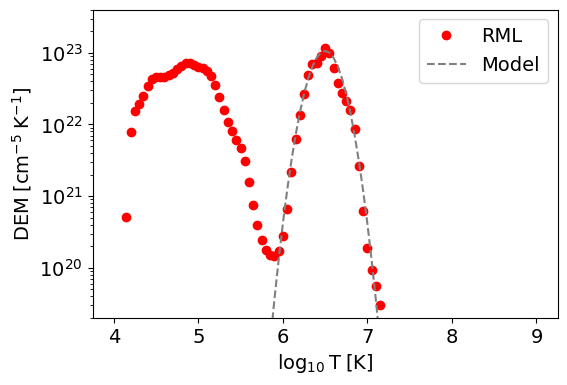

In [4]:
# the rml method expects the response to have a factor of dT in it?
tr_rml=np.zeros((nf,nt))
for i in range(nf):
    tr_rml[i,:]=trin['tr'][i]*10**tresp_logt*np.log(10**tresp_dlogt)
r_dem, r_dem_error, r_pixel = dem_rml.dem_rml(dn_in, edn_in, exptime, tr_rml, tresp_logt, tresp_dlogt,silent=True)

#  Plot it all
yr=[2e19,4e23]
fig = plt.figure(figsize=(6, 4))
plt.plot(tresp_logt,r_dem,'or',label='RML')
plt.plot(tresp_logt,dem_mod,'--',color='grey',label='Model')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
# plt.xlim(xr)
plt.yscale('log')
plt.legend()
plt.show()


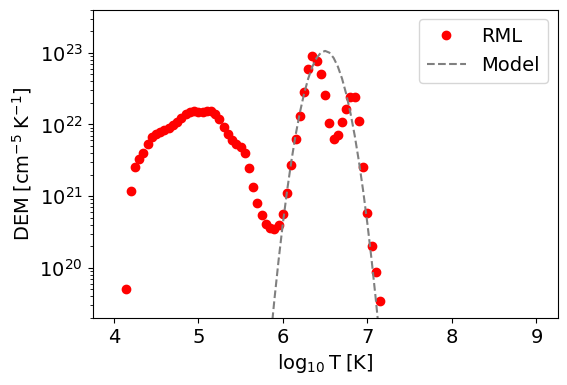

In [5]:
# try without 335?
r_dem, r_dem_error, r_pixel = dem_rml.dem_rml(dn_in[:-1], edn_in[:-1],exptime[:-1], tr_rml[:-1,:], tresp_logt, tresp_dlogt,silent=True)

#  Plot it all
yr=[2e19,4e23]
fig = plt.figure(figsize=(6, 4))
plt.plot(tresp_logt,r_dem,'or',label='RML')
plt.plot(tresp_logt,dem_mod,'--',color='grey',label='Model')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
# plt.xlim(xr)
plt.yscale('log')
plt.legend()
plt.show()


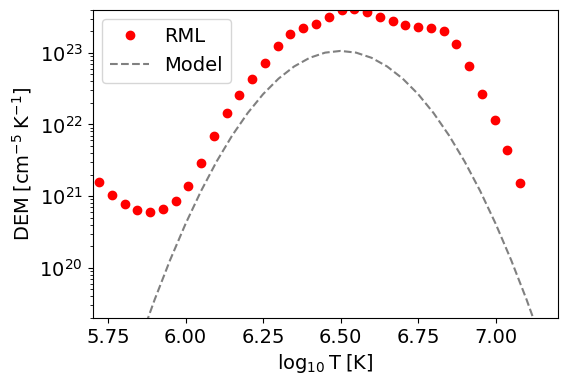

In [6]:
# Try with a different temperature binning?
temps=np.logspace(5.7,7.1,num=35)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
mlogt=np.array(mlogt)
dlogt=[np.log10(temps[i+1])-np.log10(temps[i]) for i in np.arange(0,len(temps)-1)]
dlogt=np.array(dlogt)
tresp=np.ones([nf,len(mlogt)])

for i in range(0,nf):
    dT=10**(mlogt[i]+0.5*dlogt[i])-10**(mlogt[i]-0.5*dlogt[i])
    tresp[i,:]=10**np.interp(mlogt,tresp_logt,np.log10(trin['tr'][i]))*dT

r_dem, r_dem_error, r_pixel = dem_rml.dem_rml(dn_in, edn_in, exptime, tresp, mlogt, dlogt,silent=True)

#  Plot it all
yr=[2e19,4e23]
xr=[5.7,7.2]
fig = plt.figure(figsize=(6, 4))
plt.plot(mlogt,r_dem,'or',label='RML')
plt.plot(tresp_logt,dem_mod,'--',color='grey',label='Model')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.yscale('log')
plt.legend()
plt.show()
